# Feature Extraction and Image Processing
Mark S. Nixon & Alberto S. Aguado http://www.southampton.ac.uk/~msn/book/
### Chapter 9: *MaximallyStableRegions*
Compute maximally stable regions in an image
***  

### Setup modules

In [1]:
import os
import sys
sys.path.append(os.path.join(os.path.dirname("__file__"), "../../Modules"))

# Module functions
from ImageUtilities import imageReadL, plotImageL,createImageF, plotImageF
from ImagePropertiesUtilities import imageMaxMin
from ImageRegionsUtilities import pixlesList, edgesList

# Math and iteration
from math import  sqrt
from random import shuffle
from timeit import itertools

### Parameters:
    pathToDir = Input image directory
    imageName = Input image name
    backgroundRange = The gray level range value of the background

In [2]:
pathToDir = os.path.join(os.path.dirname("__file__"), "../../Images/Chapter9/Input/")
imageName = "circles.png"
background = [200, 255] 

FLT_MAX = sys.float_info.max

### Show input image

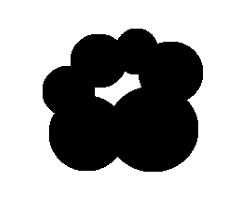

In [3]:
inputImage, width, height = imageReadL(pathToDir+imageName)
plotImageL(inputImage, figureSize = 3)

### Generate list of pixels

In [4]:
# Get a list that contains the pixels of the shape in the form (y,x,v) 
shapeImage = pixlesList(inputImage, background)
numPoints = len(shapeImage)

# Get a list of edge pixels
edgePixels = edgesList(inputImage, shapeImage, background)

### Compute the radial distance to the edge

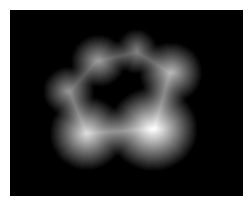

In [5]:
distanceImage = createImageF(width, height)
numEdges = len(edgePixels)
for indexPixel in range(0, numPoints):
    y, x = (shapeImage[indexPixel])[0], (shapeImage[indexPixel])[1]
    minEdgeDist = FLT_MAX
    for indexEdge in range(0, numEdges):
        edgeY, edgeX = (edgePixels[indexEdge])[0], (edgePixels[indexEdge])[1]
        minEdgeDist = min(minEdgeDist, sqrt((edgeX-x)**2+(edgeY-y)**2))
    distanceImage[y,x] = minEdgeDist 
    
# Show distance
plotImageF(distanceImage, figureSize = 3)

### Create initial regions

In [6]:
# Watershed image
watershed = createImageF(width, height)

# Initial regions by finding the maximum
suppWindow = 5    # Window used to find a maximum
regionIndex = 1   # Start id for a region
for indexPixel in range(0, numPoints):        
    y, x = (shapeImage[indexPixel])[0], (shapeImage[indexPixel])[1]
    if watershed[y,x] == 0:
        peak = True
        for wx,wy in itertools.product(range(x-suppWindow, x+suppWindow+1),    \
                                       range(y-suppWindow, y+suppWindow+1)):
            if wy>=0 and wy<height and wx>=0 and wx<width:               
                if watershed[wy, wx] != 0 or                                   \
                   distanceImage[y, x] < distanceImage[wy, wx]:
                    peak = False
        if peak:
            for wx,wy in itertools.product(range(x-suppWindow, x+suppWindow+1), \
                                           range(y-suppWindow, y+suppWindow+1)):
                if wy>=0 and wy<height and wx>=0 and wx<width:
                    watershed[wy, wx] = regionIndex
            regionIndex += 1
            

### Flood 

In [7]:
floodRegion = [ ] # The region we need to flood
for indexPixel in range(0, numPoints):        
    y, x = (shapeImage[indexPixel])[0], (shapeImage[indexPixel])[1]
    if watershed[y,x] == 0:
        floodRegion.append((y,x))

# Flooding
maxDistance, _ = imageMaxMin(distanceImage)
for floodValue in range(int(maxDistance), 0, -1):
    flooded = True
    while flooded:
        flooded = False
        newFloodRegion = [ ]
        growRegion = [ ]
        shuffle(floodRegion)
        for indexPixel in range(0, len(floodRegion)):
            y, x = (floodRegion[indexPixel])[0], (floodRegion[indexPixel])[1]
            
            # Points not flooded will be considered in following iterations
            if distanceImage[y,x] <= floodValue:
                newFloodRegion.append((y,x))
            else:
                n = [ ] #  List of neighbours
                for wx,wy in itertools.product(range(-1, 2), range(-1, 2)):        
                    posX, posY = x + wx, y+ wy
                    if posY > -1 and posY < height and  posX > -1 and posX < width:
                        if watershed[posY, posX] != 0:
                            n.append(watershed[posY, posX])
                 
                # No neighbours, so we cannot grow
                if(len(n) == 0):
                    newFloodRegion.append((y,x))
                else:
                    # Grow of only one type of region
                    if len(set(n)) == 1:
                        growRegion.append((y,x,n[0]))
                        flooded  = True
                        
        for pixel in growRegion:   
            y, x, idRegion = pixel[0] , pixel[1] , pixel[2] 
            watershed[y, x] = idRegion
       
        floodRegion = newFloodRegion

#### Set the borders

In [8]:
shedID = regionIndex + 1
for indexPixel in range(0, numPoints):        
    y, x = (shapeImage[indexPixel])[0], (shapeImage[indexPixel])[1]
    if watershed[y,x] == 0 and distanceImage[y, x] > 0.5:
        watershed[y, x] = shedID   

#### Show result

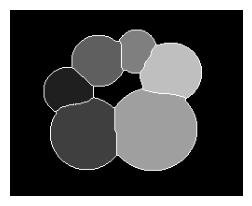

In [10]:
plotImageF(watershed, figureSize = 3)